In [1]:
import jax
import jax.numpy as np
import jraph
import flax.linen as nn
import numpy as onp
import matplotlib.pyplot as plt

from functools import partial

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../")

from models.gnn import GraphConvNet
from models.graph_utils import nearest_neighbors
from models.graph_utils import add_graphs_tuples
from datasets import load_data

In [56]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "CMU Serif"
})

In [4]:
k = 10
n_batch = 1

In [125]:
n_nodes = 75

x = np.load("/Users/smsharma/Downloads/halos_small.npy")[:, :n_nodes, :]

x_mean = x.mean((0, 1))
x_std = x.std((0, 1))
x[:, :, 3:] = (x[:, :, 3:] - x_mean[3:]) / x_std[3:]
x[:, :, :3] = x[:, :, :3] / 1000.

In [126]:
sources, targets = jax.vmap(nearest_neighbors, in_axes=(0, None))(x[:n_batch], k)

## EGNN

In [127]:
from models.egnn import EGNN

In [128]:
class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, x):
        model = jax.vmap(EGNN(
                        message_passing_steps=3, d_hidden=32, n_layers=3, skip_connections=False, activation='gelu'
                ))
        return model(x)
    
model = GraphWrapper()
rng = jax.random.PRNGKey(42)

## Test equivariance

In [129]:
from models.graph_utils import rotate_representation

In [130]:
graph = jraph.GraphsTuple(
          n_node=np.array(n_batch * [[n_nodes]]), 
          n_edge=np.array(n_batch * [[k]]),
          nodes=x[0:n_batch, :, :], 
          edges=None,
          globals=np.ones((n_batch, 7)),
          senders=sources,
          receivers=targets)

graph_out, _ = model.init_with_output(rng, graph)

x_out = graph_out.nodes

angle_deg = 45.
axis = np.array([0, 1 / np.sqrt(2), 1 / np.sqrt(2)])

x_out_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x_out, angle_deg, axis)

def get_rotated(x_rot):

    graph = jraph.GraphsTuple(
              n_node=np.array(n_batch * [[n_nodes]]), 
              n_edge=np.array(n_batch * [[k]]),
              nodes=x_rot,
              edges=None,
              globals=np.ones((n_batch, 7)),
              senders=sources,
              receivers=targets)

    graph_out, params = model.init_with_output(rng, graph)
    x_out = graph_out.nodes
    
    return x_out

x_out = get_rotated(jax.vmap(rotate_representation, in_axes=(0,None,None))(x[0:n_batch, :, :], angle_deg, axis))

In [131]:
# # Equivariance ratio
# eq_ratio = x_out / x_out_rot
# print(eq_ratio.max(), eq_ratio.min(), eq_ratio)

0


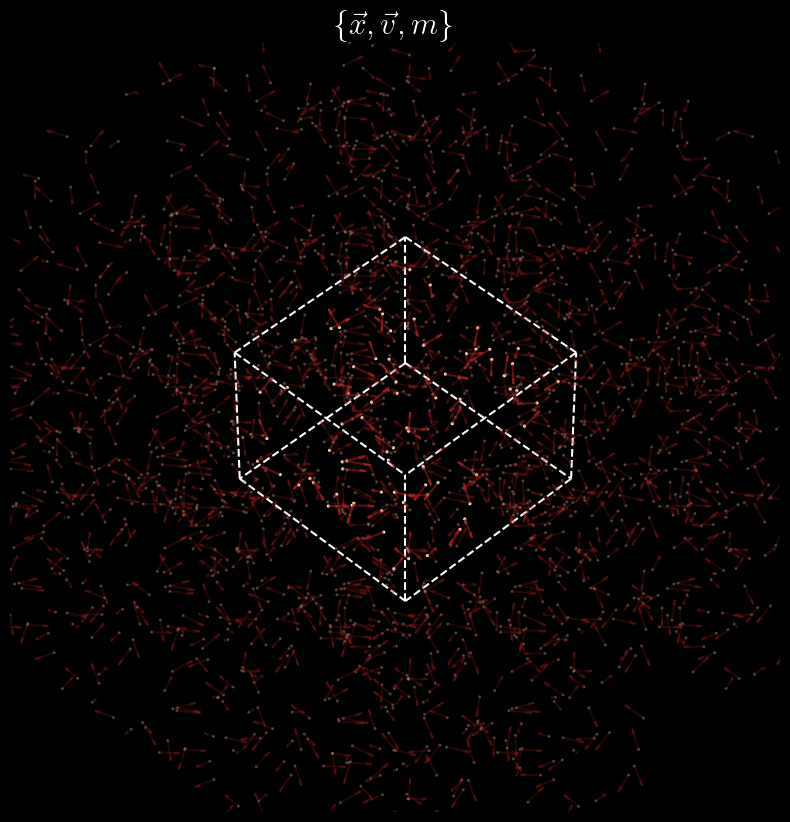

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from itertools import product, combinations

plt.style.use('dark_background')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10., 10.), subplot_kw={'projection': '3d'})

xx, yy, zz = np.zeros((3,3))
uu, vv, ww = 2. * np.array([[1,0,0],[0,1,0],[0,0,1]])

def update(frame):
    
    ax.clear()
            
    angle_deg = 0.
    axis = np.array([0, 1., 0])
    # x_tran = translations[frame]
            
    x_rot = np.array(jax.vmap(rotate_representation, in_axes=(0,None,None))(x, angle_deg, axis))
    # x_rot[:, :, :3] += x_tran[None, None, :]

    x_plot = x_rot[0, :, :3]
    velocities_plot = x_rot[0, :, 3:6]
    masses_plot = 5 * np.exp(x_rot[0, :, -1])
    
    # original points
    ax.scatter(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2], alpha=1., s=masses_plot, color="bisque")
    ax.quiver(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2],
                  velocities_plot[:, 0], velocities_plot[:, 1], velocities_plot[:, 2],
                  length=0.1, normalize=True, color="firebrick", alpha=0.5)
    
    alpha_outside = 0.2
    # repeating points in adjacent cells
    offsets = [-1, 0, 1]
    for dx in offsets:
        for dy in offsets:
            for dz in offsets:
                if dx == 0 and dy == 0 and dz == 0:  # skip the original cell
                    continue
                ax.scatter(x_plot[:, 0]+dx, x_plot[:, 1]+dy, x_plot[:, 2]+dz, alpha=alpha_outside, s=masses_plot, color="bisque")
                ax.quiver(x_plot[:, 0]+dx, x_plot[:, 1]+dy, x_plot[:, 2]+dz,
                          velocities_plot[:, 0], velocities_plot[:, 1], velocities_plot[:, 2],
                          length=0.1, normalize=True, color="firebrick", alpha=alpha_outside)

    # plot unit cell
    r = [0, 1]
    for s, e in combinations(np.array(list(product(r, r, r))), 2):
        if np.sum(np.abs(s-e)) == r[1]-r[0]:
            ax.plot3D(*zip(s, e), color="white", ls='--')

    angle = np.mod(np.linspace(45, 45 + 360, num_frames), 360)[frame]
    print(frame)
    
    ax.view_init(angle, angle, 0)
    # ax.quiver(xx,yy,zz,uu,vv,ww, arrow_length_ratio=0.1, color='white', alpha=0.6)
    ax.set_title(r"$\{\vec x, \vec v, m\}$", fontsize=23)

    ax.set_axis_off()
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    ax.set_zlim(-0.5, 1.5)

num_frames = 100
update(0)
plt.savefig("/Users/smsharma/Desktop/pbc2.pdf")

In [160]:
ani = FuncAnimation(fig, update, frames=np.arange(num_frames))
plt.tight_layout()

import matplotlib.animation as animation
FFwriter = animation.FFMpegWriter(fps=20)
ani.save('/Users/smsharma/Desktop/pbc.mp4', writer=FFwriter, dpi=400)

plt.show()

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<Figure size 640x480 with 0 Axes>

In [133]:
def random_smooth_trajectories(num_frames, total_points=1000):
    t = np.linspace(0, 1, total_points)
    
    # Generate coefficients for smooth rotation angles (in degrees) and axes
    angle_coefficients = np.random.uniform(-45., 45., size=(4, 1))
    axis_coefficients = np.random.uniform(-0.8, 0.8, size=(4, 3))
    
    # Generate smooth rotation angles (in degrees) for each frame
    rotation_angles_all = angle_coefficients[0] * np.sin(np.pi * angle_coefficients[1] * t[:, np.newaxis]) \
                        + angle_coefficients[2] * np.cos(np.pi * angle_coefficients[3] * t[:, np.newaxis])

    # Generate smooth rotation axes for each frame
    rotation_axes_all = axis_coefficients[0] * np.sin(np.pi * axis_coefficients[1] * t[:, np.newaxis]) \
                      + axis_coefficients[2] * np.cos(np.pi * axis_coefficients[3] * t[:, np.newaxis])

    # Normalize the rotation axes
    rotation_axes_all /= np.linalg.norm(rotation_axes_all, axis=1)[:, np.newaxis]

    # Generate coefficients for smooth translations
    translation_coefficients = np.random.uniform(-0.5, 0.5, size=(4, 3))

    # Generate smooth translations for each frame
    translations_all = translation_coefficients[0] * np.sin(np.pi * translation_coefficients[1] * t[:, np.newaxis]) \
                     + translation_coefficients[2] * np.cos(np.pi * translation_coefficients[3] * t[:, np.newaxis])

    # Select a subset of points based on the desired number of frames
    indices = np.linspace(0, total_points - 1, num_frames).astype(int)
    rotation_angles = rotation_angles_all[indices]
    rotation_axes = rotation_axes_all[indices]
    translations = translations_all[indices]

    return rotation_angles, rotation_axes, translations

t_sec = 16
fps = 20
num_frames = int(fps * t_sec)
rotation_angles, rotation_axes, translations = random_smooth_trajectories(num_frames)

In [164]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

plt.style.use('dark_background')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5), subplot_kw={'projection': '3d'})

# Add overarching title
fig.suptitle(r"$E(3)$ equivariance test", fontsize=30)

# # Adjust spacing around subplots to reduce whitespace
# fig.subplots_adjust(left=0.13, right=0.9, top=0.92, bottom=0.02)

xx, yy, zz = np.zeros((3,3))
uu, vv, ww = 3. * np.array([[1,0,0],[0,1,0],[0,0,1]])

def update(frame):
    
    print(frame)
    
    axs[0].clear()
    axs[1].clear()
    
    angle_deg = rotation_angles[frame][0]
    axis = rotation_axes[frame]
    x_tran = translations[frame]
            
    x_rot = np.array(jax.vmap(rotate_representation, in_axes=(0,None,None))(x, angle_deg, axis))
    x_rot[:, :, :3] += x_tran[None, None, :]

    x_plot = x_rot[0, :, :3]
    velocities_plot = x_rot[0, :, 3:6]
    masses_plot = 50 * np.exp(x_rot[0, :, -1])


    axs[0].scatter(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2], alpha=0.8, s=masses_plot, color="bisque")
    axs[0].quiver(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2],
                  velocities_plot[:, 0], velocities_plot[:, 1], velocities_plot[:, 2],
                  length=0.3, normalize=True, color="firebrick", alpha=0.5)


    axs[0].view_init(45, 45, 0)
    axs[0].quiver(xx,yy,zz,uu,vv,ww, arrow_length_ratio=0.1, color='white', alpha=0.6)
    axs[0].set_title(r"$\{\vec x, \vec v, m\}$", fontsize=23)

    axs[0].set_axis_off()
    axs[0].set_xlim(-2, 2)
    axs[0].set_ylim(-2, 2)
    axs[0].set_zlim(-2, 2)

    x_out = get_rotated(x_rot[:n_batch])

    x_plot = x_out[0, :, :3]
    velocities_plot = x_out[0, :, 3:6]
    masses_plot = 50 * np.exp(x_out[0, :, -1])

    axs[1].scatter(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2], alpha=0.8, s=masses_plot, color="bisque")
    axs[1].quiver(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2],
                  velocities_plot[:, 0], velocities_plot[:, 1], velocities_plot[:, 2],
                  length=0.3, normalize=True, color="firebrick", alpha=0.5)


    axs[1].view_init(45, 45, 0)
    axs[1].quiver(xx,yy,zz,uu,vv,ww, arrow_length_ratio=0.1, color='white', alpha=0.6)

    axs[1].set_title(r"$\{\vec x', \vec v', m'\} = \mathrm{EGNN}(\{\vec x, \vec v, m\})$", fontsize=23)

    axs[1].set_axis_off()
    axs[1].set_xlim(-2, 2)
    axs[1].set_ylim(-2, 2)
    axs[1].set_zlim(-2, 2)

    plt.tight_layout()

ani = FuncAnimation(fig, update, frames=np.arange(num_frames))
plt.tight_layout()

# Save the animation as a gif
# ani.save('3d_animation.gif', writer='imagemagick', fps=5)

import matplotlib.animation as animation
FFwriter = animation.FFMpegWriter(fps=20)
ani.save('/Users/smsharma/Desktop/3d_animation2.mp4', writer=FFwriter, dpi=400)

plt.show()